In [79]:
# libraries 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [4]:
df = pd.read_csv('car-price-data.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_') # snake case columns

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index) 

for c in categorical_columns: # snake case all `objects` in columns
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [5]:
# top 10
df.head(10)

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500
5,bmw,1_series,2012,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,31200
6,bmw,1_series,2012,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,26,17,3916,44100
7,bmw,1_series,2012,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,39300
8,bmw,1_series,2012,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,36900
9,bmw,1_series,2013,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,27,18,3916,37200


In [14]:
# keep these columns
k = ['make',
     'model',
     'year',
     'engine_hp',
     'engine_cylinders',
     'transmission_type',
     'vehicle_style',
     'highway_mpg',
     'city_mpg',
     'msrp'
    ]
df_k = df[k]

In [15]:
df_k.isnull().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64

In [16]:
# fill with 0
df_k.engine_hp = df_k.engine_hp.fillna(0)
df_k.engine_cylinders = df_k.engine_cylinders.fillna(0)

<ipython-input-16-081aa8abe701>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_k.engine_hp = df_k.engine_hp.fillna(0)
<ipython-input-16-081aa8abe701>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_k.engine_cylinders = df_k.engine_cylinders.fillna(0)


In [17]:
average = df_k['msrp'].mean()

df_k['above_average'] = np.where(df_k['msrp'] >= average, 1, 0) # bool column 


<ipython-input-17-1178f25db862>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_k['above_average'] = np.where(df_k['msrp'] >= average, 1, 0) # bool column


In [18]:
df_k

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp,above_average
0,bmw,1_series_m,2011,335.0,6.0,manual,coupe,26,19,46135,1
1,bmw,1_series,2011,300.0,6.0,manual,convertible,28,19,40650,1
2,bmw,1_series,2011,300.0,6.0,manual,coupe,28,20,36350,0
3,bmw,1_series,2011,230.0,6.0,manual,coupe,28,18,29450,0
4,bmw,1_series,2011,230.0,6.0,manual,convertible,28,18,34500,0
...,...,...,...,...,...,...,...,...,...,...,...
11909,acura,zdx,2012,300.0,6.0,automatic,4dr_hatchback,23,16,46120,1
11910,acura,zdx,2012,300.0,6.0,automatic,4dr_hatchback,23,16,56670,1
11911,acura,zdx,2012,300.0,6.0,automatic,4dr_hatchback,23,16,50620,1
11912,acura,zdx,2013,300.0,6.0,automatic,4dr_hatchback,23,16,50920,1


In [22]:
df_full_train, df_test = train_test_split(df_k, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

# less brute force than `del` idk
df_train = df_train.drop(columns='above_average')
df_val = df_val.drop(columns='above_average')
df_test = df_test.drop(columns='above_average')

# Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables.

For each numerical variable, use it as score and compute AUC with the above_average variable
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

In [23]:
df_k.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               11914 non-null  object 
 1   model              11914 non-null  object 
 2   year               11914 non-null  int64  
 3   engine_hp          11914 non-null  float64
 4   engine_cylinders   11914 non-null  float64
 5   transmission_type  11914 non-null  object 
 6   vehicle_style      11914 non-null  object 
 7   highway_mpg        11914 non-null  int64  
 8   city_mpg           11914 non-null  int64  
 9   msrp               11914 non-null  int64  
 10  above_average      11914 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 1024.0+ KB


In [33]:
# exploring numerical values 
display(df_k['engine_cylinders'].unique())
display(df_k['engine_cylinders'].nunique()) 

array([ 6.,  4.,  5.,  8., 12.,  0., 10.,  3., 16.])

9

In [34]:
numericals = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

In [41]:
def log_reg(numerical): 

    dv = DictVectorizer(sparse=False)

    train_dict = df_train[numerical].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    val_dict = df_val[numerical].to_dict(orient='records')
    X_val = dv.transform(val_dict)

    y_pred = model.predict_proba(X_val)[:, 1]
    
    return roc_auc_score(y_val, y_pred)

In [42]:
log_reg(['engine_hp']) # highest auc 

0.9153308465235073

In [43]:
log_reg(['engine_cylinders'])

0.7690689320336834

In [44]:
log_reg(['highway_mpg'])

0.6286428845579014

In [45]:
log_reg(['city_mpg'])

0.6699949414821458

# Question 2

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

`LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`

What's the AUC of this model on the validation dataset? (round to 3 digits)

- `0.678`
- `0.779`
- `0.878`
- `0.979`


In [46]:
columns_to_use = ['make', 'model', 'year', 'engine_hp', 'engine_cylinders', 'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg']

In [47]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[columns_to_use].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [48]:
val_dict = df_val[columns_to_use].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.9793883084563915

# Question 3

Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01

For each threshold, compute precision and recall. Plot them

At which threshold precision and recall curves intersect?

- 0.28
- 0.48
- 0.68
- 0.88

In [49]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [56]:
# first 10
scores[:10]

[(0.0, 654, 1729, 0, 0),
 (0.01, 652, 763, 2, 966),
 (0.02, 651, 638, 3, 1091),
 (0.03, 651, 548, 3, 1181),
 (0.04, 650, 485, 4, 1244),
 (0.05, 650, 463, 4, 1266),
 (0.06, 648, 424, 6, 1305),
 (0.07, 648, 403, 6, 1326),
 (0.08, 647, 371, 7, 1358),
 (0.09, 646, 348, 8, 1381)]

In [50]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [58]:
df_scores

,threshold,tp,fp,fn,tn,p,r
0,0.00,654,1729,0,0,0.274444,1.000000
1,0.01,652,763,2,966,0.460777,0.996942
2,0.02,651,638,3,1091,0.505043,0.995413
3,0.03,651,548,3,1181,0.542952,0.995413
4,0.04,650,485,4,1244,0.572687,0.993884
...,...,...,...,...,...,...,...
96,0.96,280,1,374,1728,0.996441,0.428135
97,0.97,267,1,387,1728,0.996269,0.408257
98,0.98,237,0,417,1729,1.000000,0.362385
99,0.99,202,0,452,1729,1.000000,0.308869


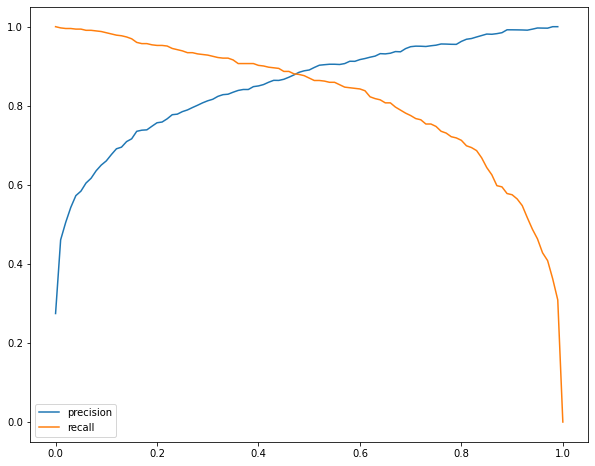

In [69]:
plt.figure(figsize=(10,8))

plt.plot(df_scores['threshold'].values, df_scores['p'].values, label='precision');
plt.plot(df_scores['threshold'].values, df_scores['r'].values, label='recall');
plt.legend();

# Question 4 
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52
- 0.72


In [70]:
df_scores['f1'] = 2 * (df_scores.p * df_scores.r) / (df_scores.p + df_scores.r)

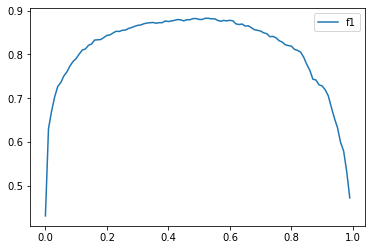

In [74]:
plt.plot(df_scores.threshold.values, df_scores['f1'].values, label='f1')
plt.legend();

In [75]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns_to_use].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [76]:
dv, model = train(df_train, y_train, 1.0)

In [77]:
def predict(df, dv, model):
    dicts = df[columns_to_use].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [78]:
y_pred = predict(df_val, dv, model)

In [81]:
y_pred

array([0.98078164, 0.06249248, 0.01512884, ..., 0.00169736, 0.0048522 ,
       0.95264172])

In [80]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.935 +- 0.003
C=0.01 0.952 +- 0.002
C=0.1 0.972 +- 0.002
C=0.5 0.978 +- 0.002
C=1 0.982 +- 0.003
C=5 0.980 +- 0.003
C=10 0.983 +- 0.003
